# Readme Seymour 
#### By Heather McMillan
#### Desiree McElroy
#### Carl Griffin



In [2]:
import pandas as pd
import numpy as np
import unicodedata
import re
import nltk

# imports for visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm # for colormap tools
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

# import modules 
import prepare as p
import acquire as a
import explore as ex
import model as m

# imports for NLP extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# imports for modeling
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score, plot_confusion_matrix

# visualization settings
plt.rc('figure', figsize=(13, 7))
plt.rc('font', size=16)
plt.style.use('seaborn-darkgrid')
sns.set_palette('viridis')

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

## Overview and Goals
The goal of this project is to determine the main coding language of a project based on the contents of it's github Readme, using NLP methods. The data was acquired from various repositories on Github. In order to recreate this project you will need to access the json of the data we acquired. During the acquisition of the repo names, we filtered for the word customer, not for any particular reason other than something to filter for. 

A total of 193 Repos were obtained but after dropping nulls, readmes with Chinese characters, and slimming it down to the top most prevalent languages in our dataset we ended up with data from 106 different documents. The 4 languages that we filtered for were, Java, JavaScript, PHP, and Jupyter Notebook. 

## Findings
We found that an SVC model using Lemmatized data, and  performed the highest with an accuracy of 81% on the validate data set (unseen). With a final test accuracy of INSERT NUMBER HERE. 



In [3]:
# read in data from Json
df = pd.read_json('data2.json')

# take a peak at it
df.head()

repo    language  \
0         codingXiaxw/CustomerManagement        Java   
1              DanWahlin/CustomerManager  JavaScript   
2          Tophold/FinancialCustomerView        Java   
3      DanWahlin/CustomerManagerStandard  JavaScript   
4  spring-cloud-samples/customers-stores        Java   

                                     readme_contents  
0  ## JavaWeb项目之客户管理系统 \n\n## 项目介绍\n详细讲解请点击这里前往我的...  
1  Customer Manager with AngularJS (with custom r...  
2  ## FinancialCustomerView\n* 本项目会对金融交易软件中存在的各种V...  
3  Customer Manager with AngularJS\r\n===========...  
4  # REST based micro-services sample\n\n- Three ...

It looks like we have some Chinese in here. Let's take a look at the different coding languages we have.

In [4]:
df.language.value_counts(dropna = False)

PHP                 41
Jupyter Notebook    32
JavaScript          25
Java                23
Python              20
C#                  12
NaN                  7
R                    4
HTML                 4
TypeScript           4
Go                   3
Vue                  3
Ruby                 3
Dart                 2
CSS                  2
HCL                  2
PowerShell           2
Objective-C          1
Scala                1
ABAP                 1
Shell                1
Swift                1
Name: language, dtype: int64

Since we have so many different types of languages here let's take the top 4 and filter for those. Maybe in a later model we can come back and create models for some other languages.

In [5]:
# we're going to drop chinese rows, unused languages, and any empty languages if we have any
df = p.drop_unneeded_data(df)

# we'll also prepare the data for NLP processing dropping a few words 
# that were present in almost all the readmes
df = p.prepare_nlp_data(df, content = 'readme_contents', extra_words=['customer', 'customers', '1', '2'])

In [6]:
# take a look at what we have remaining
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             106 non-null    object
 1   language         106 non-null    object
 2   readme_contents  106 non-null    object
 3   clean            106 non-null    object
 4   stemmed          106 non-null    object
 5   lemmatized       106 non-null    object
dtypes: object(6)
memory usage: 5.1+ KB


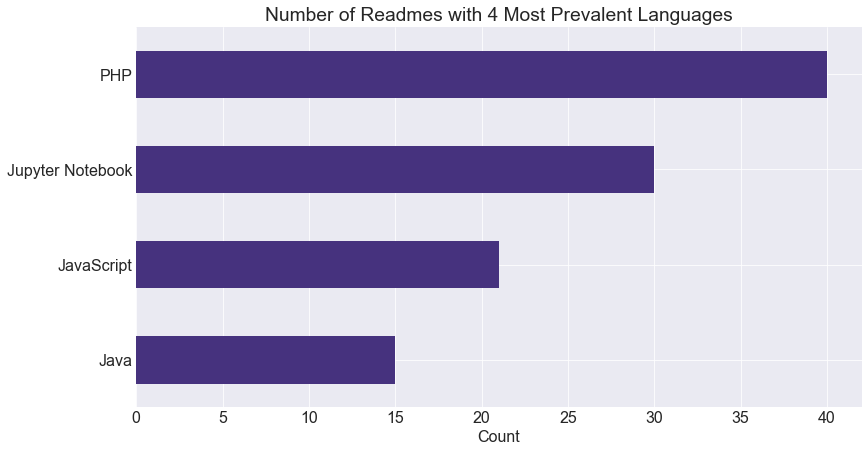

In [7]:
df.language.value_counts().sort_values(ascending = True).plot.barh()
plt.title('Number of Readmes with 4 Most Prevalent Languages')
plt.xlabel("Count")
plt.show()

In [8]:
# data is now cleaned lemmatized and stemmed for us to explore with
df.head()

repo          language  \
0                          DanWahlin/CustomerManager        JavaScript   
1                  DanWahlin/CustomerManagerStandard        JavaScript   
2              spring-cloud-samples/customers-stores              Java   
3  eventuate-tram/eventuate-tram-examples-custome...              Java   
4                Featuretools/predict-customer-churn  Jupyter Notebook   

                                     readme_contents  \
0  Customer Manager with AngularJS (with custom r...   
1  Customer Manager with AngularJS\r\n===========...   
2  # REST based micro-services sample\n\n- Three ...   
3  # Eventuate Tram Customers and Orders\n\nThis ...   
4  # A Machine Learning Framework with an Applica...   

                                               clean  \
0  manager angularjs custom routing dynamic contr...   
1  manager angularjs youre new angularjs check an...   
2  rest based microservices sample three spring b...   
3  eventuate tram orders application demonstrates...   
4  machine learning framework application predict...   

                                             stemmed  \
0  manag angularj custom rout dynam control scrip...   
1  manag angularj your new angularj check angular...   
2  rest base microservic sampl three spring boot ...   
3  eventu tram order applic demonstr two key patt...   
4  machin learn framework applic predict churn im...   

                                          lemmatized  
0  manager angularjs custom routing dynamic contr...  
1  manager angularjs youre new angularjs check an...  
2  rest based microservices sample three spring b...  
3  eventuate tram order application demonstrates ...  
4  machine learning framework application predict...

## Exploration
In this section we find that bigrams and trigrams across the different languages are fairly different while there are very few words that are 100% specific to one language or another. With a few exceptions being 'magento' found only in jupyter notebooks, and funnily the word 'notebook' is only in PHP. The word 'model' is found in PHP readmes 95% of the time. And the word 'extension' is mostly in Jupyter Notebooks but only found elsewhere in Java readmes.

We also decided to add the words customer, customers, 1, and 2 to the stopwords. They were removed in the prepare function.

In [9]:
# split in to train validate and test groups
train, validate, test = p.split_data(df)

train---> (58, 6)
validate---> (26, 6)
test---> (22, 6)


In order to see the percentages of all the words we first have to obtain counts of all the words in the text in order to visualize. We joined all the text from the readmes of the same language together, split it up into words, then did a value counts.

In [10]:
all_word_counts = ex.get_word_counts_series(train, 'lemmatized')
java_word_counts = ex.get_word_counts_series(train[train.language == 'Java'], 'lemmatized')
javascript_word_counts = ex.get_word_counts_series(train[train.language == 'JavaScript'], 'lemmatized')
php_word_counts = ex.get_word_counts_series(train[train.language == 'PHP'], 'lemmatized')
jupyter_word_counts = ex.get_word_counts_series(train[train.language == 'Jupyter Notebook'], 'lemmatized')

In [11]:
# create list of all the previous counts
word_counts_list = [java_word_counts, javascript_word_counts, php_word_counts, jupyter_word_counts, all_word_counts]

# create list of names for columns
column_names = list(df.language.unique())
column_names.append('all')

# create list of languages
languages = list(df.language.unique())

In [12]:
# create dataframe of the counts for graphing later
word_counts = pd.concat(word_counts_list, axis=1).fillna(0).astype(int)
word_counts.columns = column_names
word_counts.head()

JavaScript  Java  Jupyter Notebook  PHP  all
service             126     9                 4   20  159
order               116     4                29    5  154
saga                 58     0                 0    0   58
using                47    23                25   55  150
application          36    23                 3   13   75

<Figure size 1152x648 with 0 Axes>

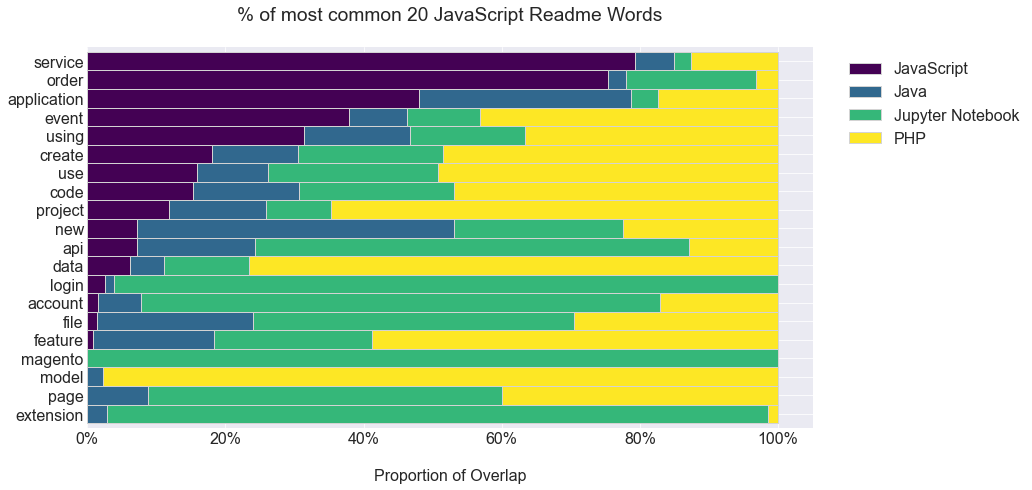

<Figure size 1152x648 with 0 Axes>

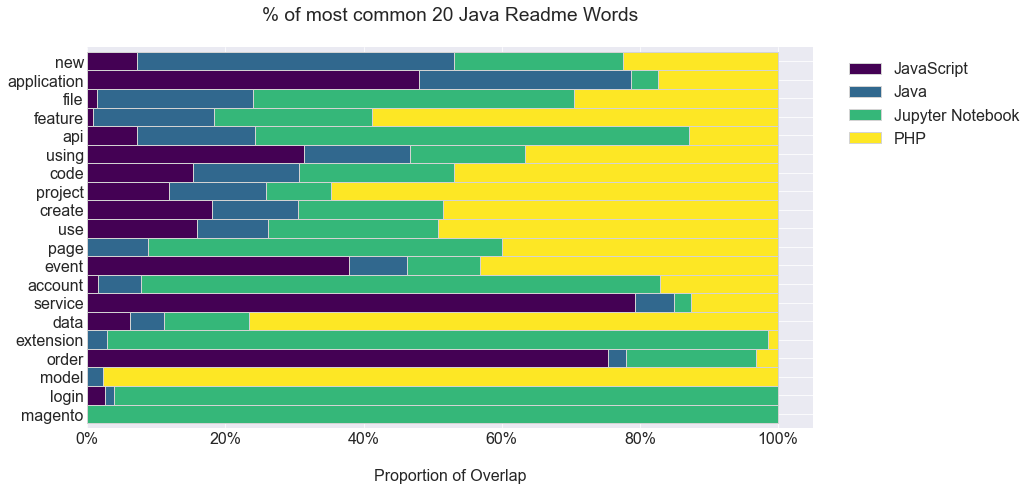

<Figure size 1152x648 with 0 Axes>

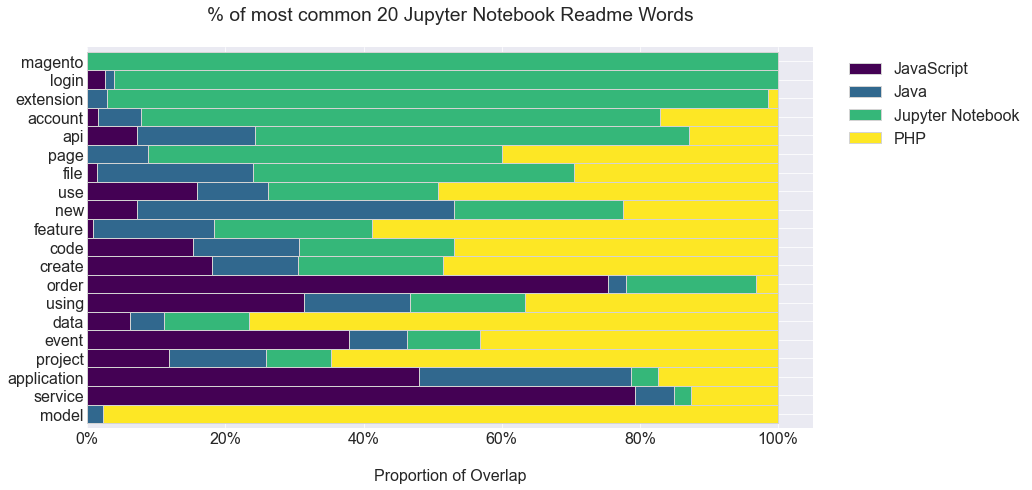

<Figure size 1152x648 with 0 Axes>

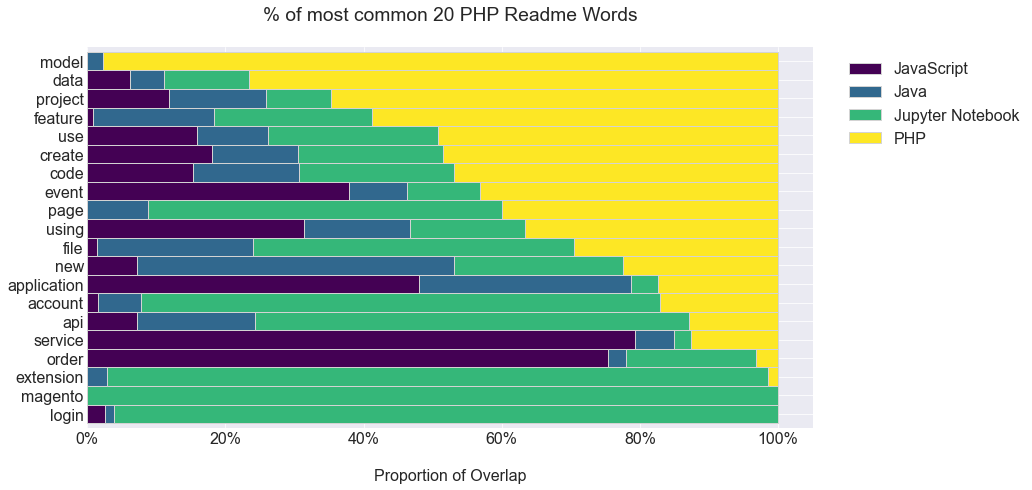

In [13]:
for language in languages:
    ex.plot_overlap_stacked_bar(word_counts, language, cmap = 'viridis')

In [14]:
# create words lists
words = ' '.join(train['lemmatized'])
all_words = words.split()

words = ' '.join(train[train.language == 'JavaScript']['lemmatized'])
javascript_words = words.split()

words = ' '.join(train[train.language == 'Java']['lemmatized'])
java_words = words.split()

words = ' '.join(train[train.language == 'PHP']['lemmatized'])
php_words = words.split()

words = ' '.join(train[train.language == 'Jupyter Notebook']['lemmatized'])
jupyter_words = words.split()


all_the_words_list = [javascript_words, java_words, jupyter_words, php_words, all_words]

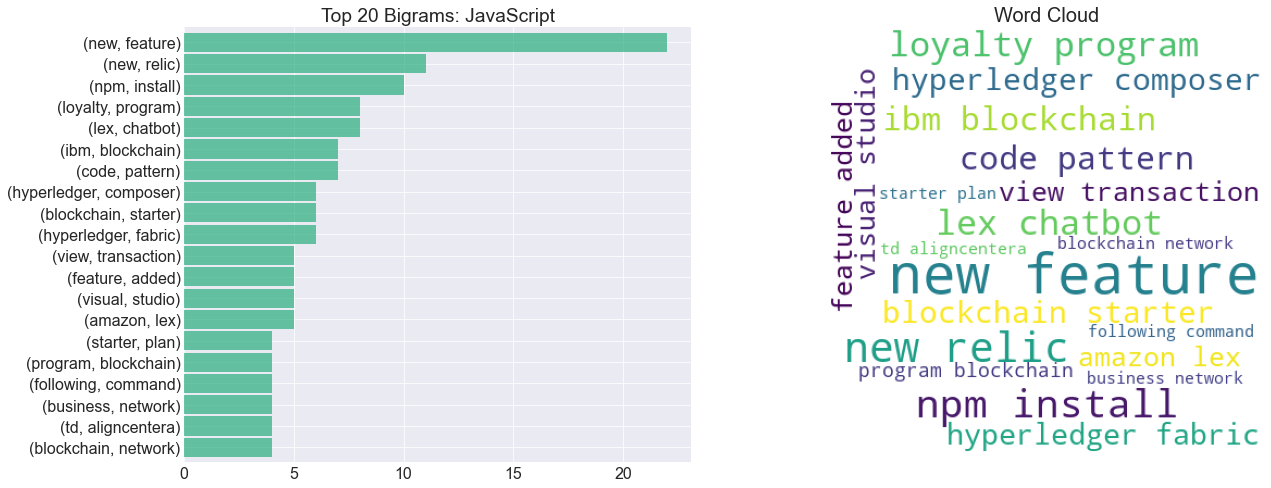

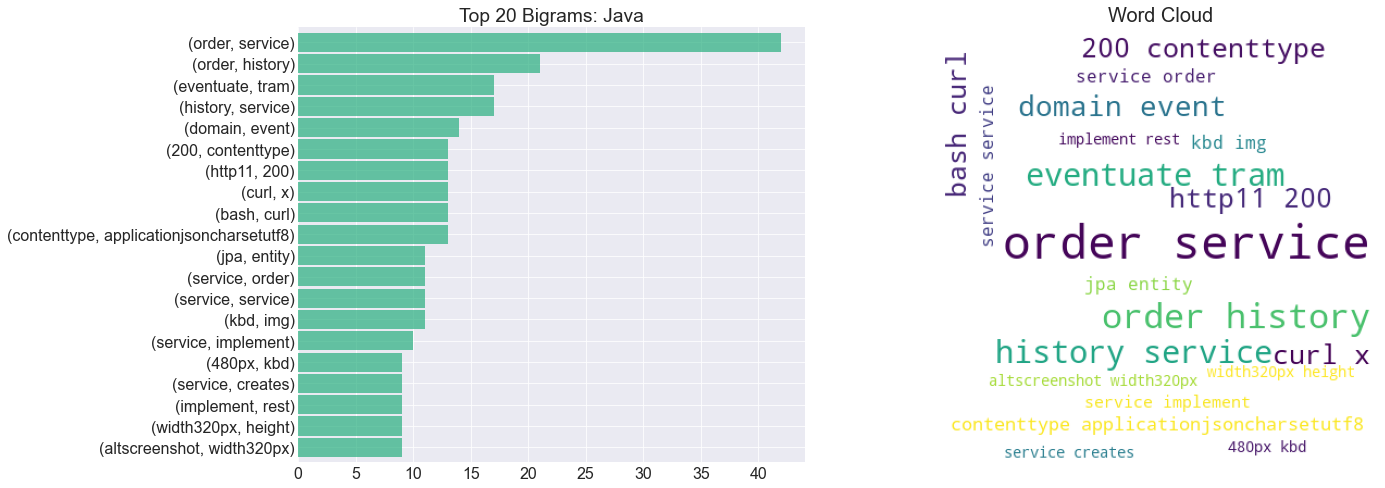

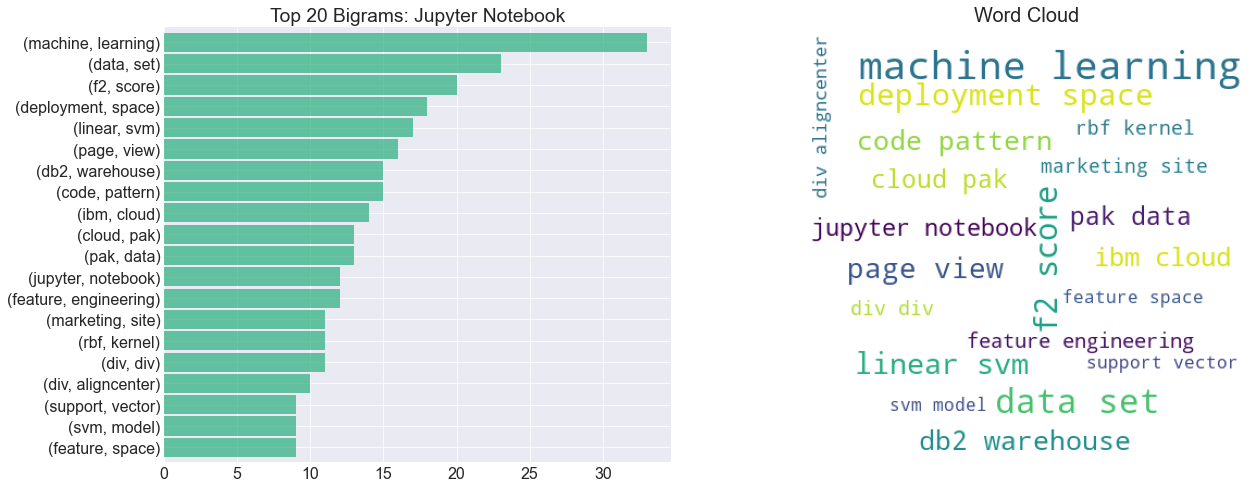

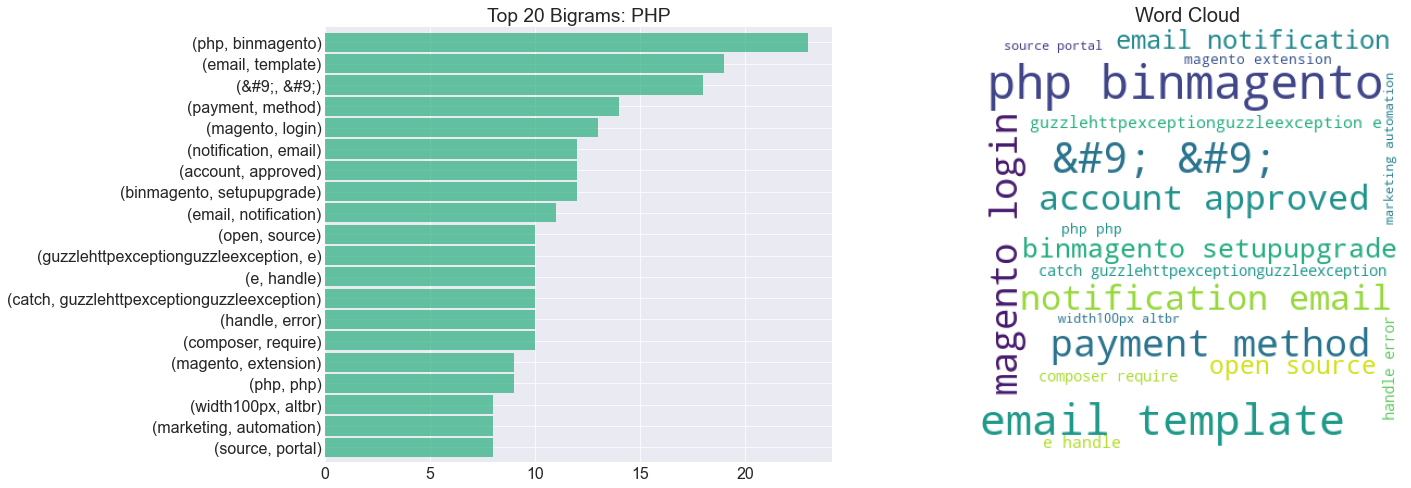

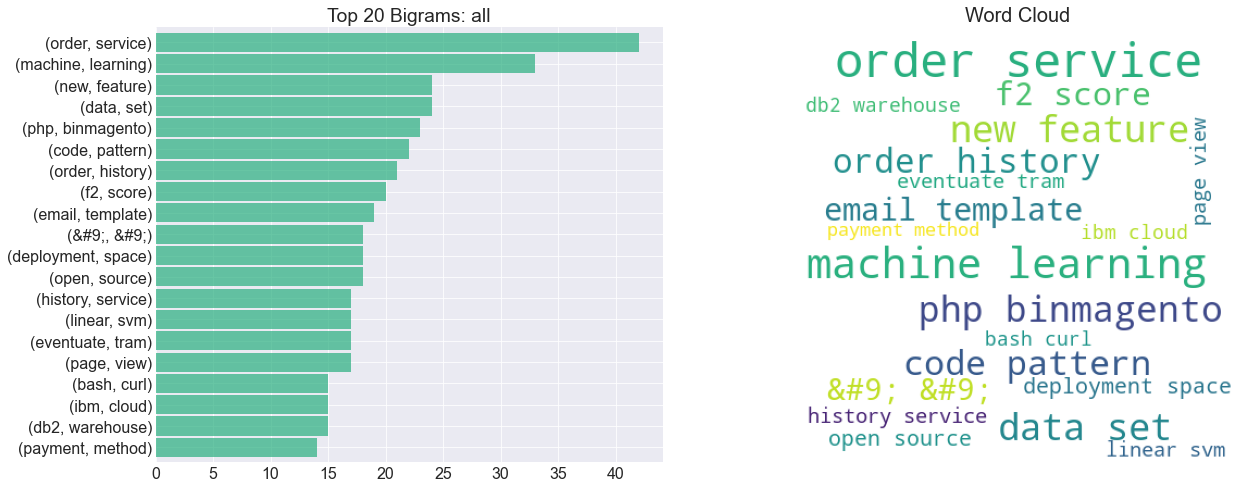

In [15]:
for x, name in zip(all_the_words_list, column_names):
    ex.bigram_count_word_cloud(x, title_name = name)

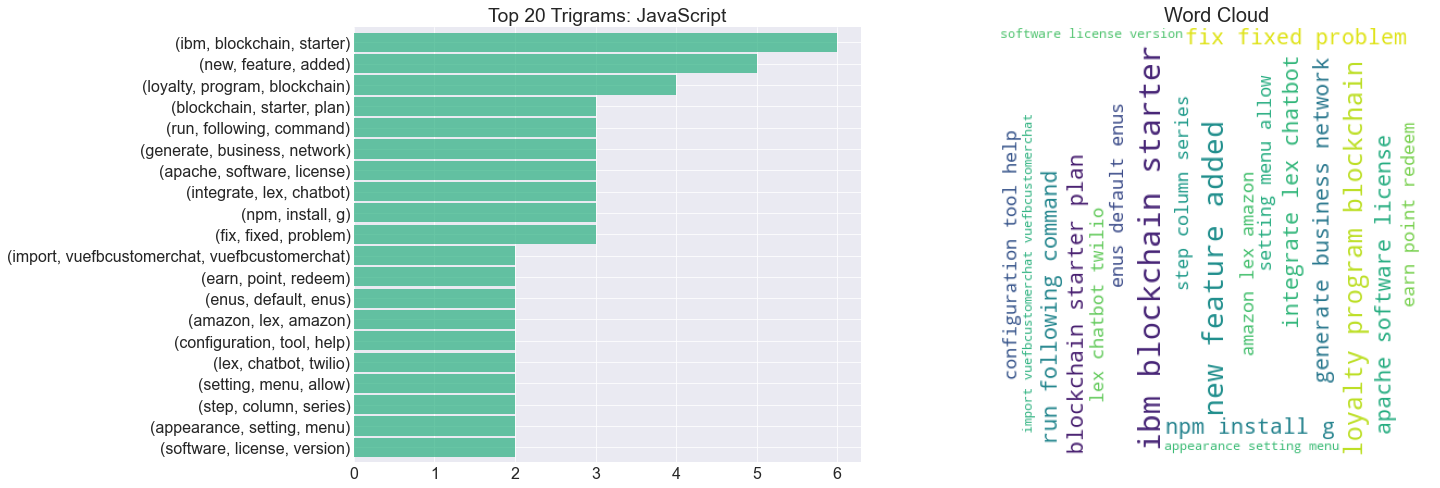

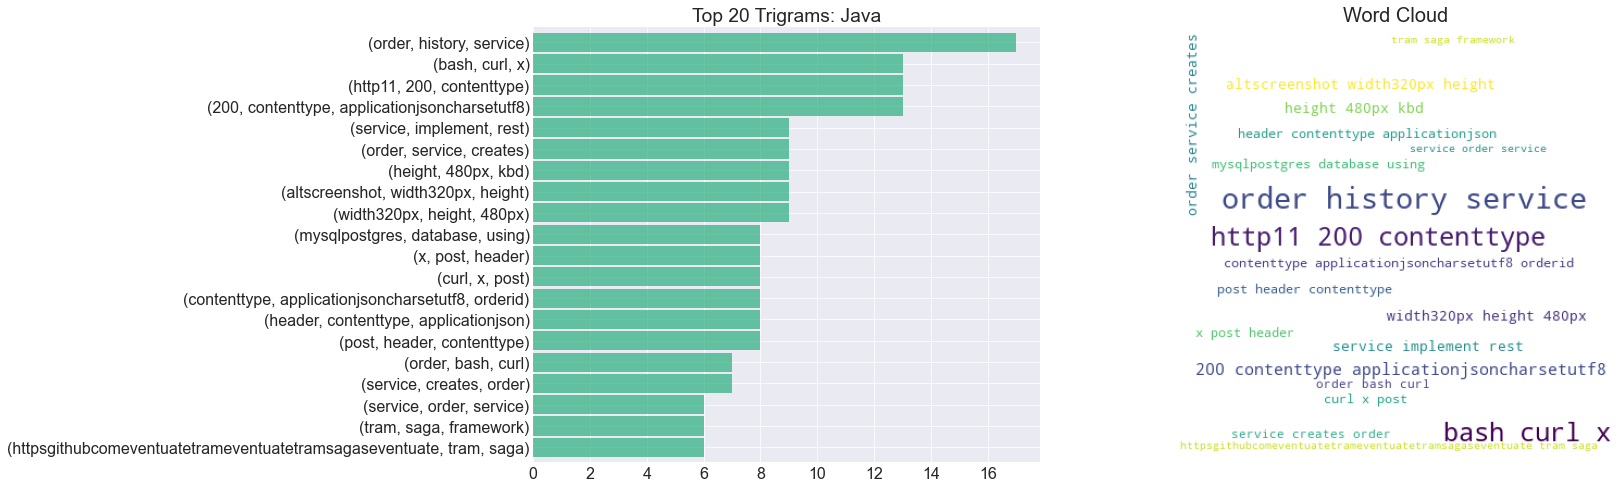

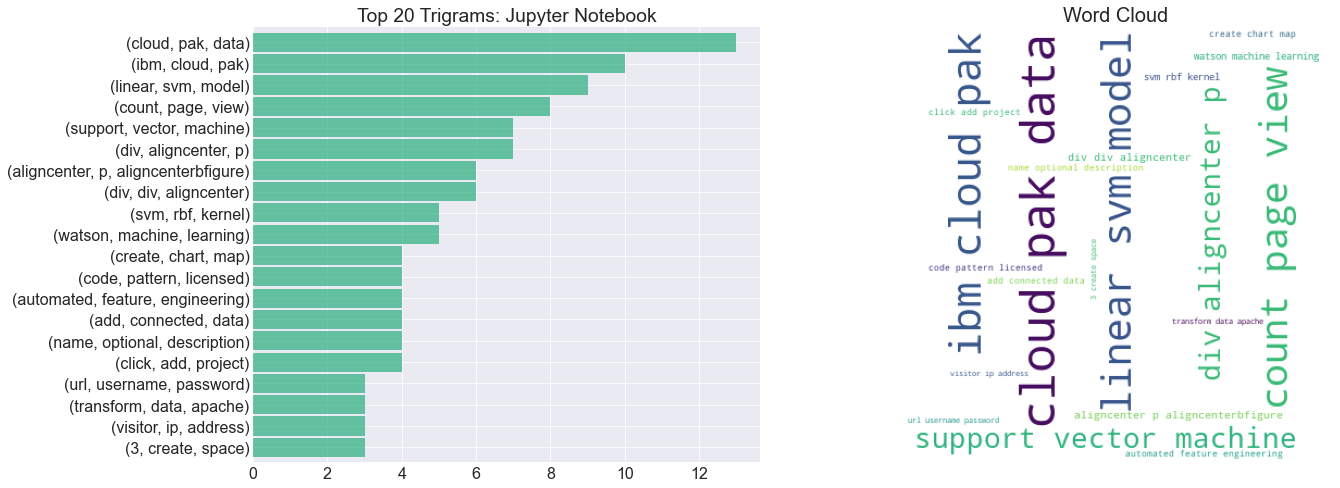

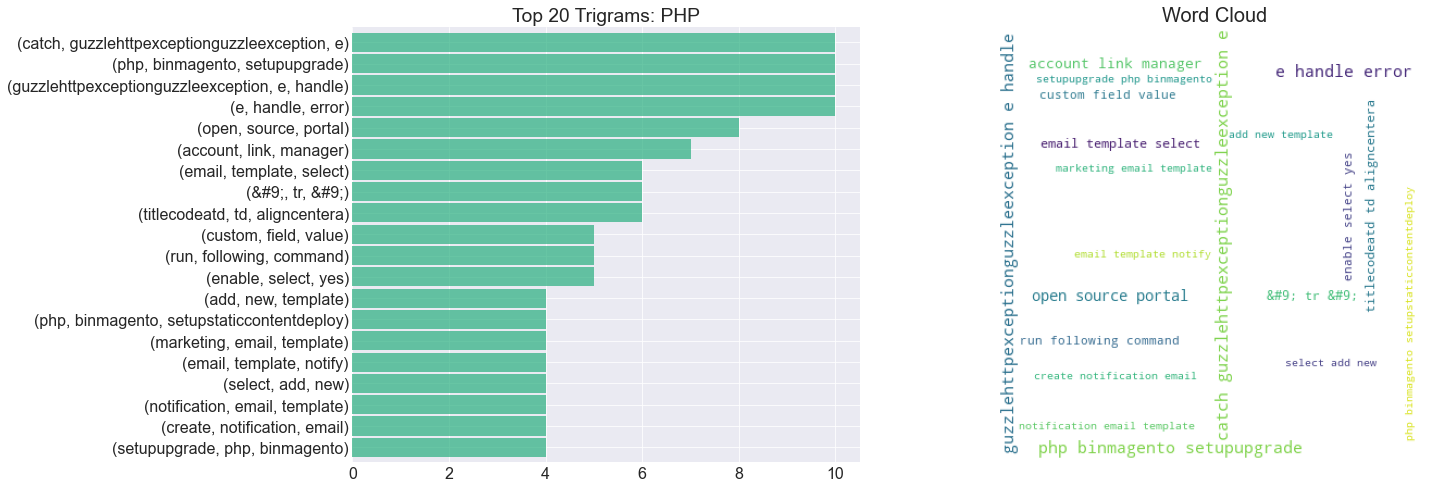

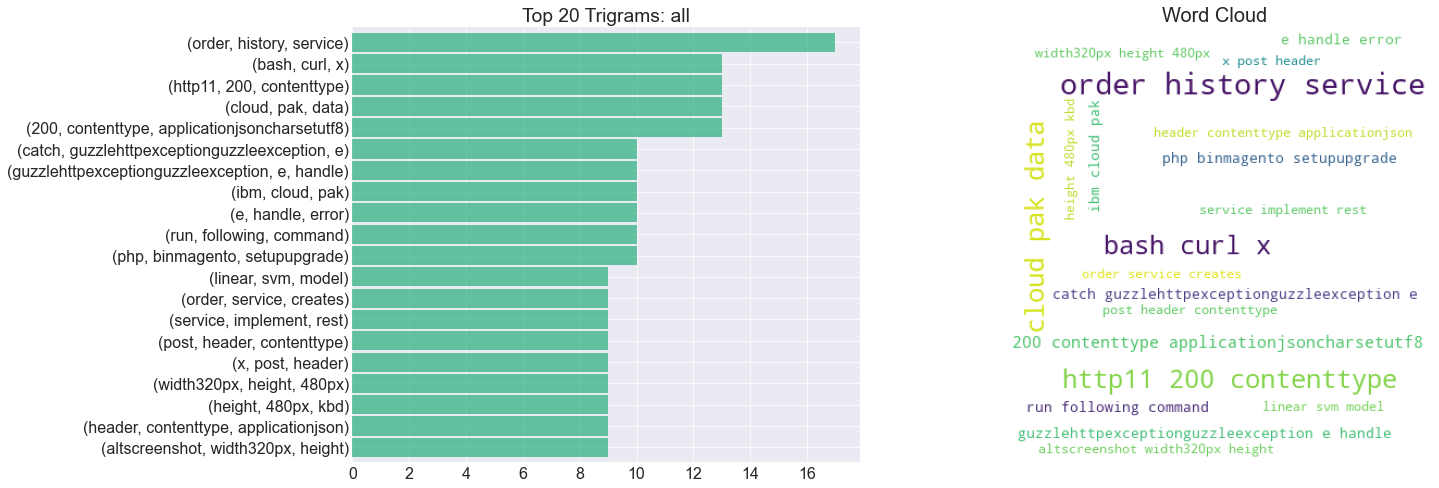

In [16]:
for x, name in zip(all_the_words_list, column_names):
    ex.trigram_count_word_cloud(x, title_name = name)

### Takeaways Bigrams and Trigrams with Lemmatized Words
- There are pretty distinct trigrams and bigrams between the different languages
- Could try modeling with both
- Some ngrams like 'watson assistant service' and 'marketing site' might be there because of the domain, we'll have to pay attention to those words during modeling

### Exploration with Stemmed words

In [17]:
# create separate dfs for the top languages utilizing stemmed data
all_word_counts = ex.get_word_counts_series(train, 'stemmed')
java_word_counts = ex.get_word_counts_series(train[train.language == 'Java'], 'stemmed')
javascript_word_counts = ex.get_word_counts_series(train[train.language == 'JavaScript'], 'stemmed')
php_word_counts = ex.get_word_counts_series(train[train.language == 'PHP'], 'stemmed')
jupyter_word_counts = ex.get_word_counts_series(train[train.language == 'Jupyter Notebook'], 'stemmed')

In [19]:
# create a list of the unique languages from the df
cols = list(df.language.unique())
cols.append('all')
cols

['JavaScript', 'Java', 'Jupyter Notebook', 'PHP', 'all']

In [21]:
# create a list from 
words_counts = [javascript_word_counts, java_word_counts, jupyter_word_counts, php_word_counts, all_word_counts]

# combine the word counts and make them into a dataframe
words_counts = pd.concat(words_counts, axis=1).fillna(0)
# assign column names
words_counts.columns = cols
words_counts.head()

JavaScript  Java  Jupyter Notebook   PHP  all
new           45.0   7.0              22.0  24.0   98
use           42.0  82.0             141.0  74.0  339
instal        35.0   8.0               5.0  45.0   93
featur        24.0   1.0              77.0  30.0  132
run           24.0   7.0              26.0  19.0   76

<Figure size 1152x648 with 0 Axes>

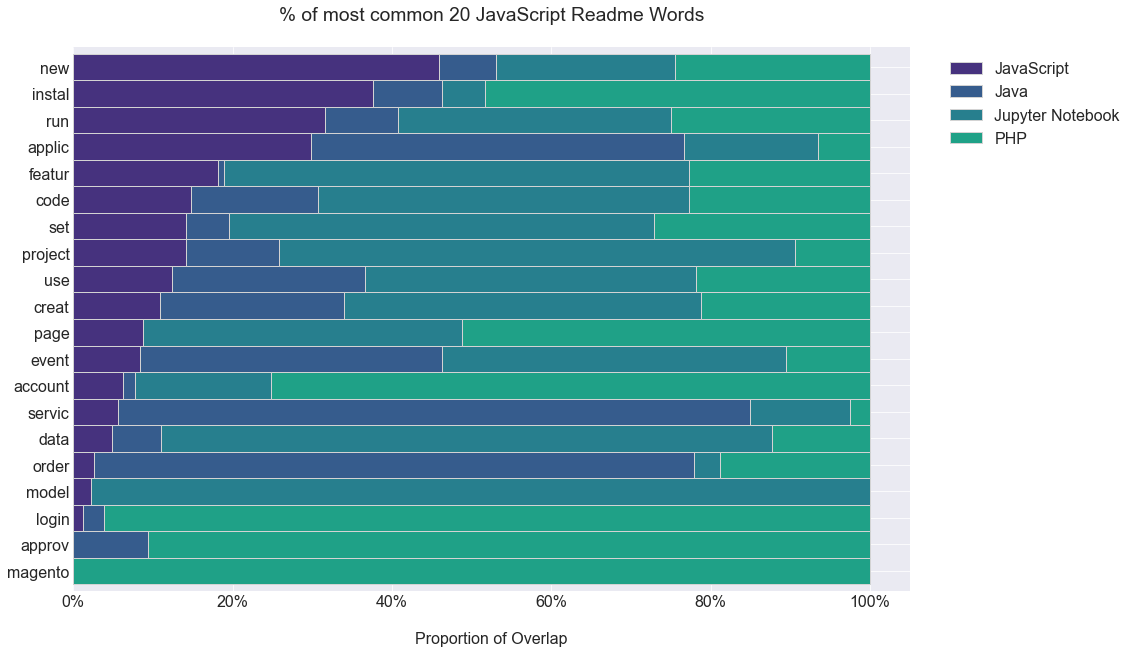

<Figure size 1152x648 with 0 Axes>

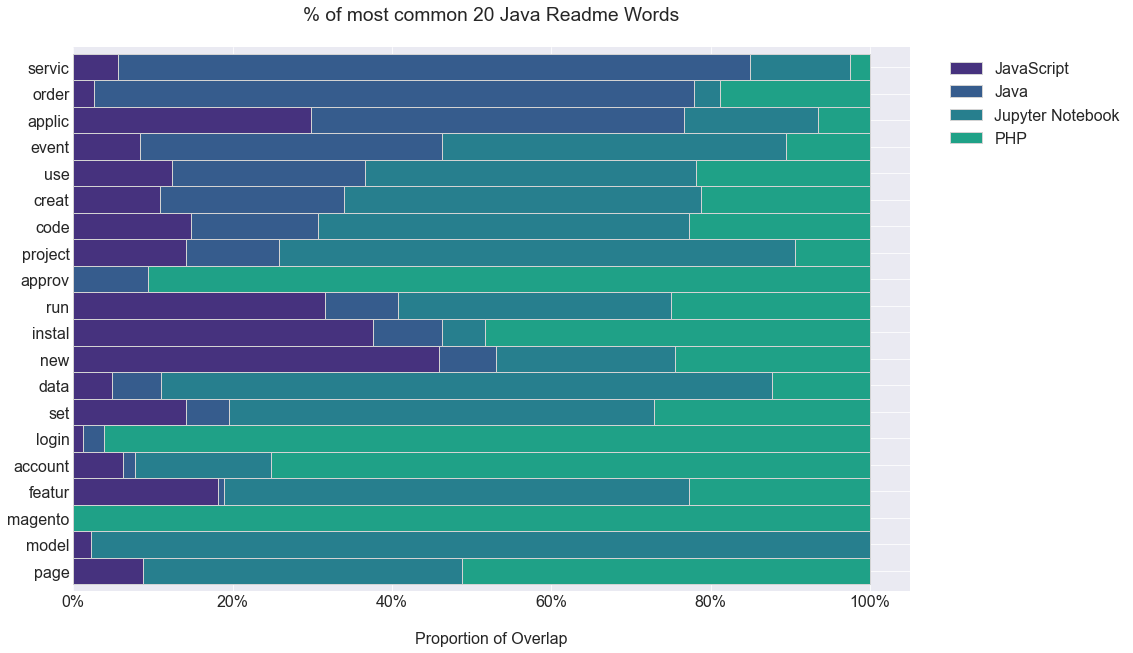

<Figure size 1152x648 with 0 Axes>

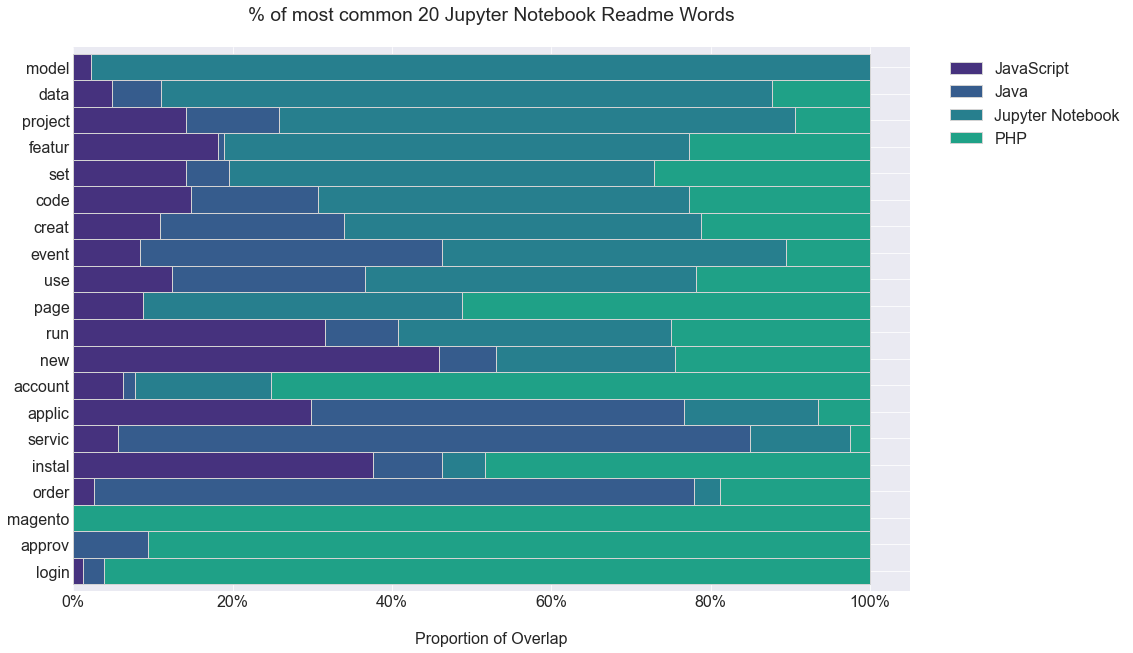

<Figure size 1152x648 with 0 Axes>

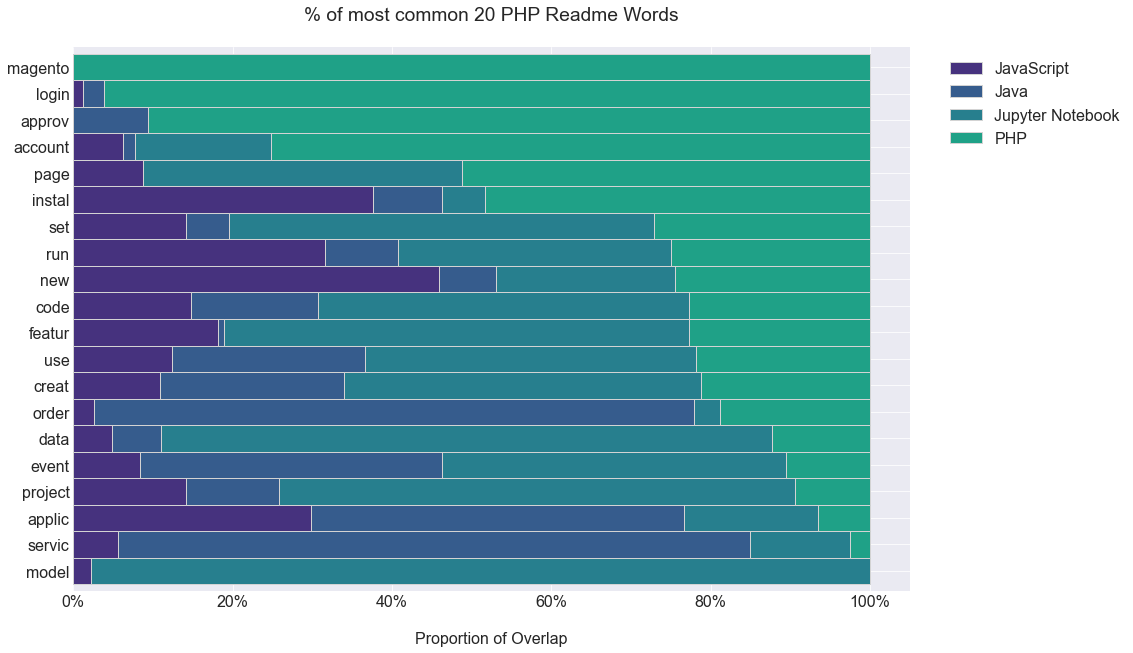

In [26]:
for i in words_counts.drop(columns='all').columns.tolist():

    plt.rc('figure',figsize=(15,10))
    ex.plot_overlap_stacked_bar(words_counts, i, num_top = 20);

**Takeaways**


We can see a commonality in numerous words such as applic, magento and model within the top 20 most words of each language.


Another thing obvious to note is the obvious cut off of words such as approv, applic and servic. This is a noticeable difference in the stemmed versus lemmatized version.

In [27]:
# create words lists from stemmed data

words = ' '.join(train['stemmed'])
all_words = words.split()

words = ' '.join(train[train.language == 'JavaScript']['stemmed'])
javascript_words = words.split()

words = ' '.join(train[train.language == 'Java']['stemmed'])
java_words = words.split()

words = ' '.join(train[train.language == 'PHP']['stemmed'])
php_words = words.split()

words = ' '.join(train[train.language == 'Jupyter Notebook']['stemmed'])
jupyter_words = words.split()


all_the_words_list = [javascript_words, java_words, jupyter_words, php_words, all_words]

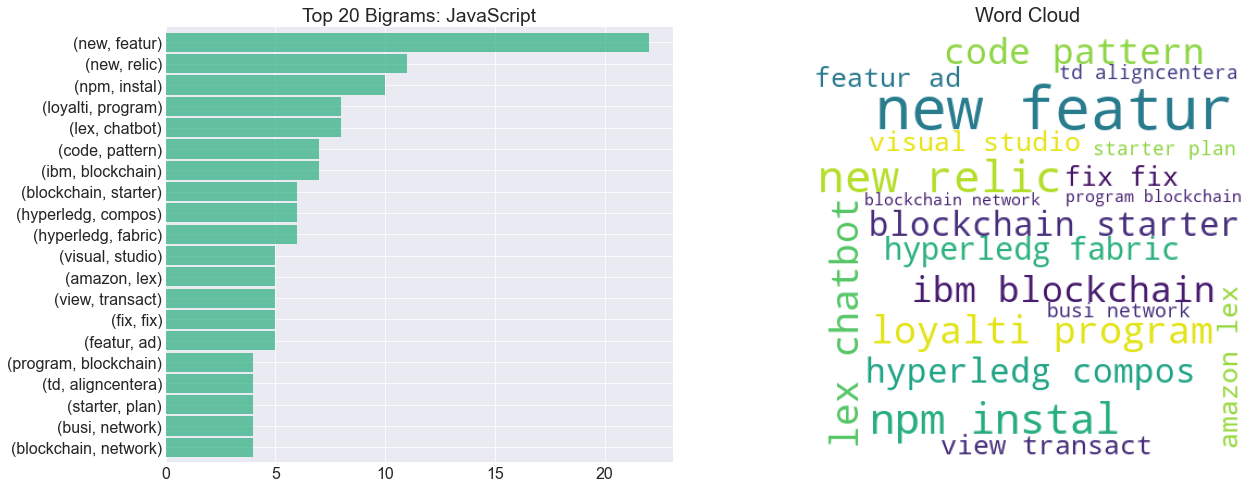

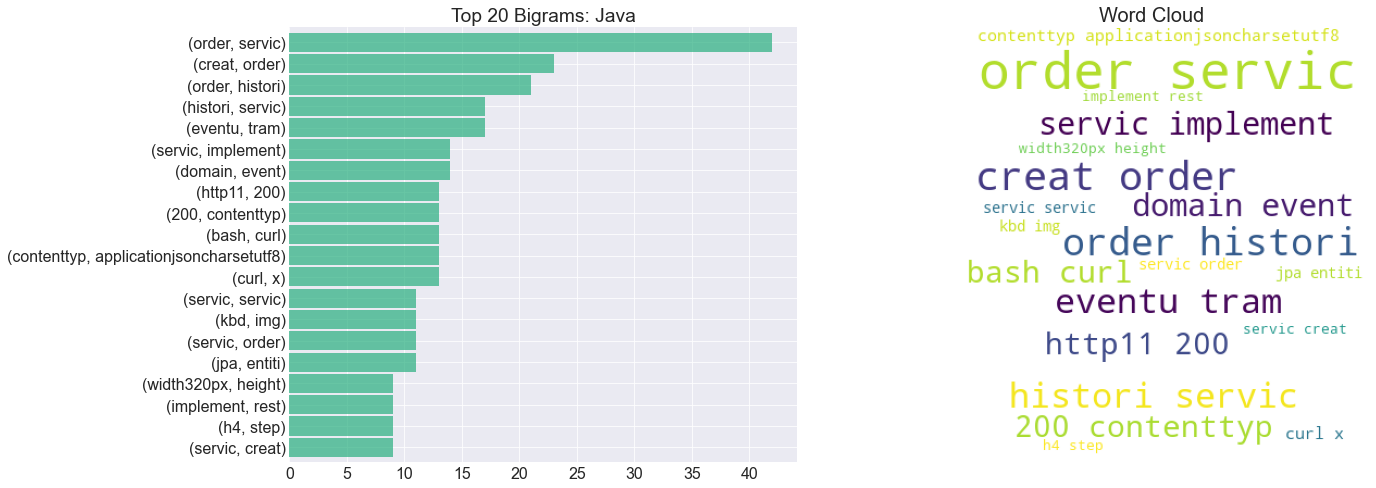

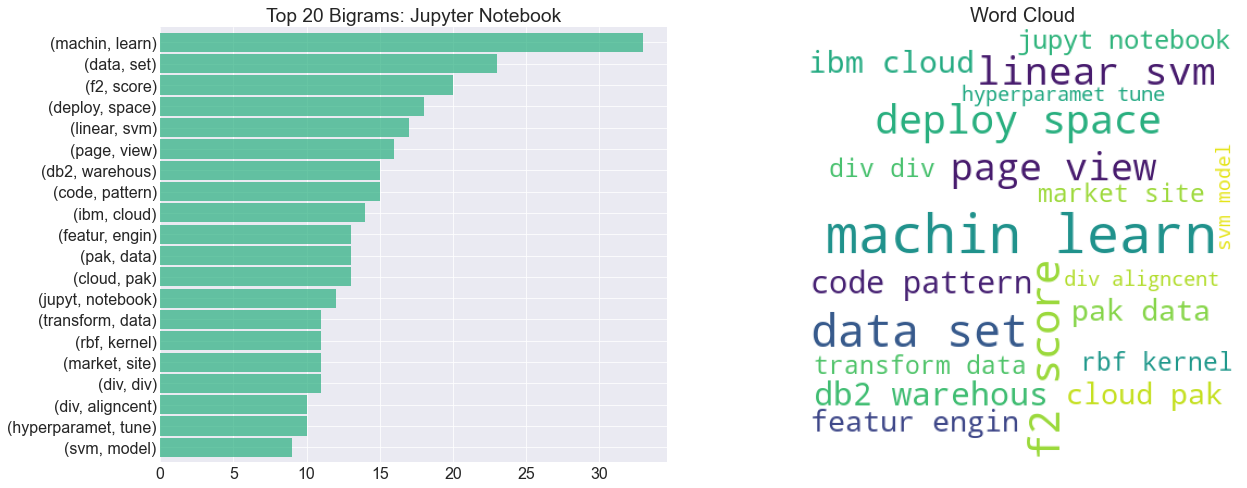

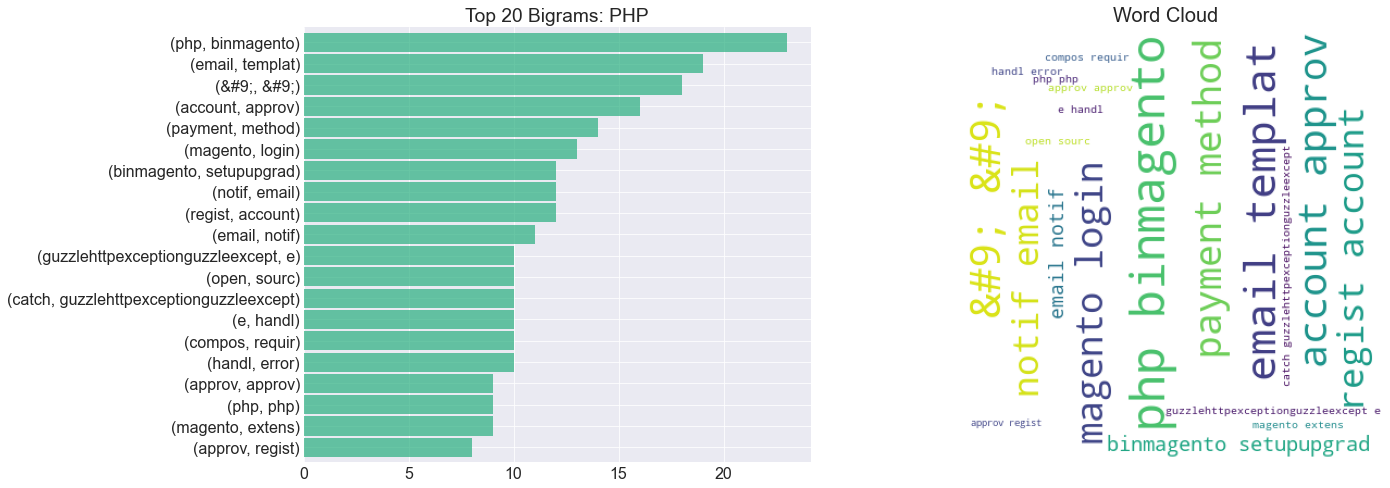

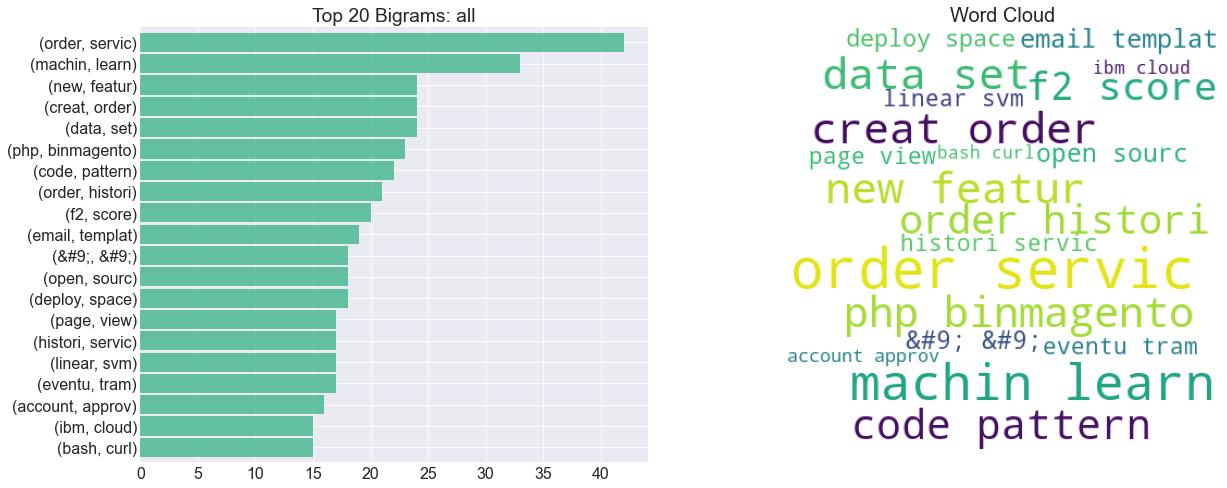

In [31]:
# take a look at the most common bigrams
for x, name in zip(all_the_words_list, cols):
    ex.bigram_count_word_cloud(x, title_name = name)

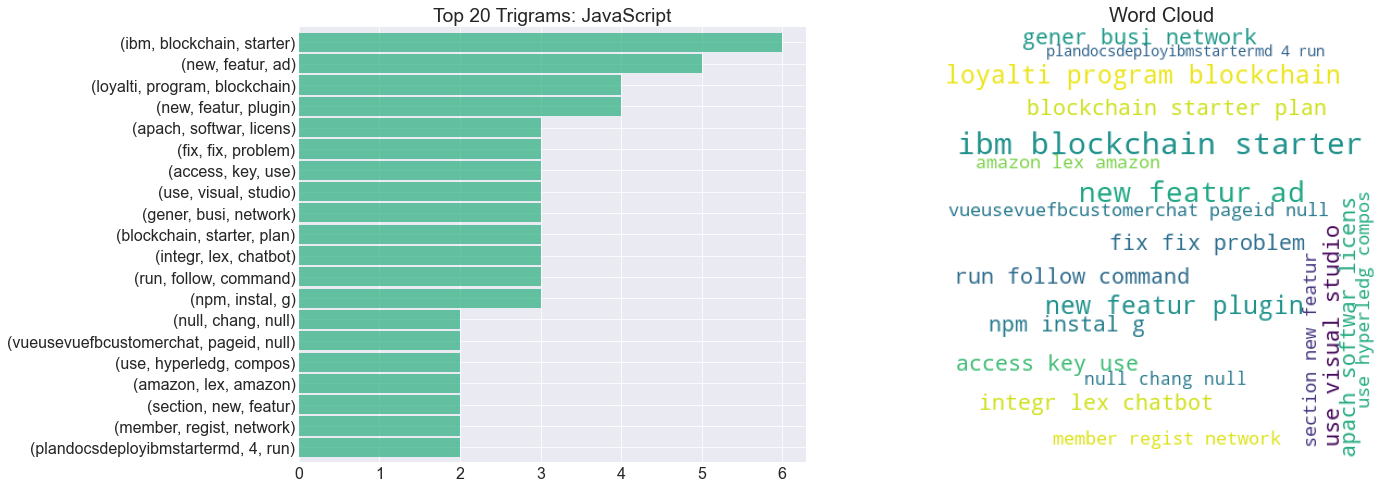

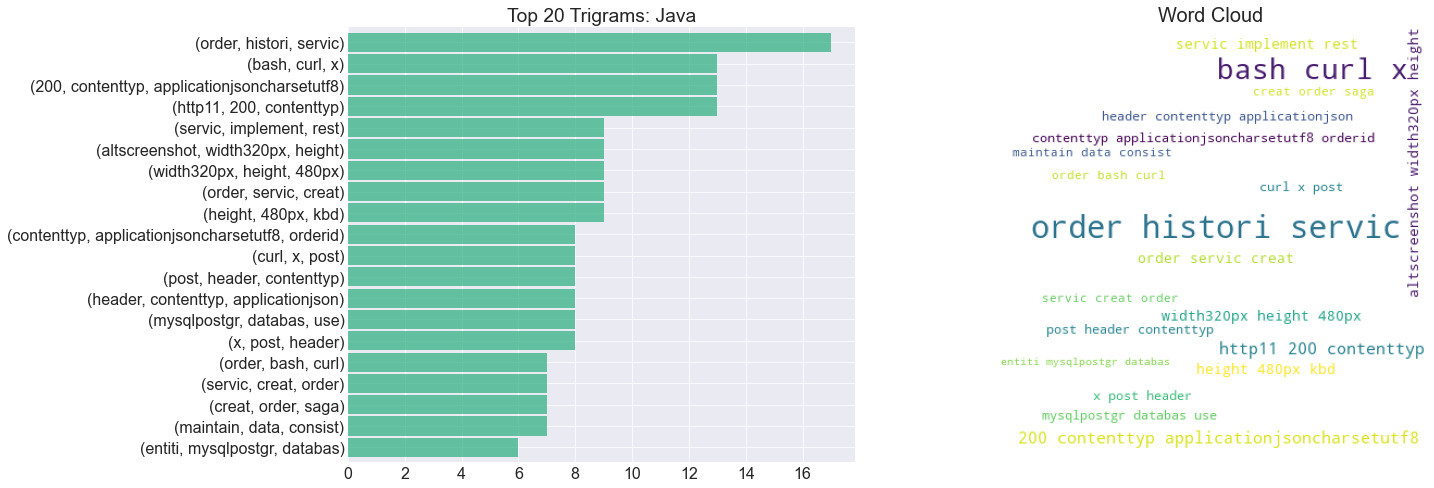

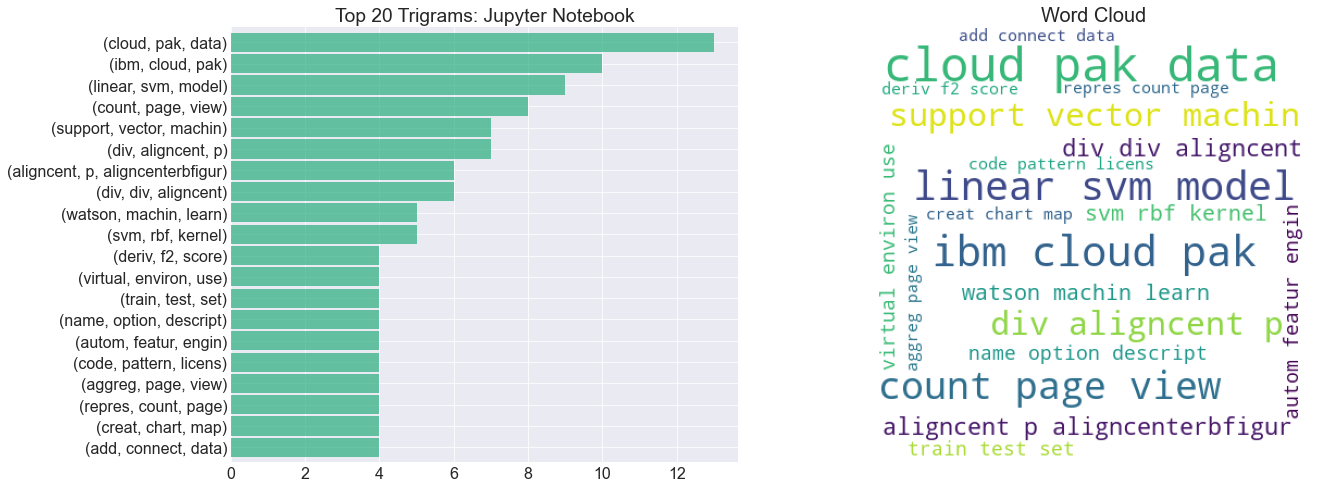

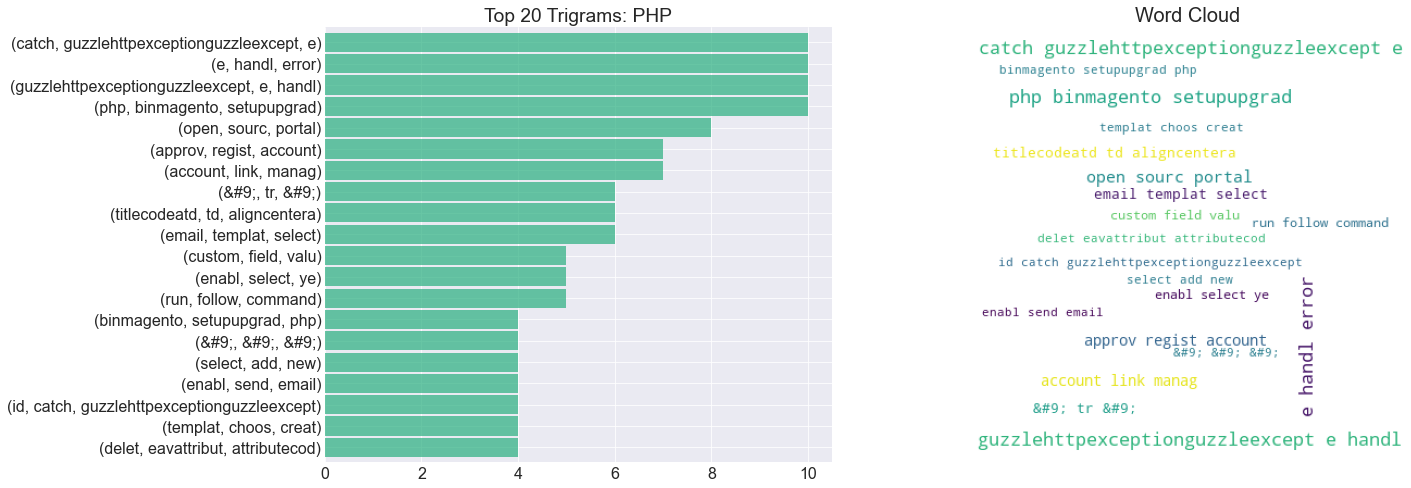

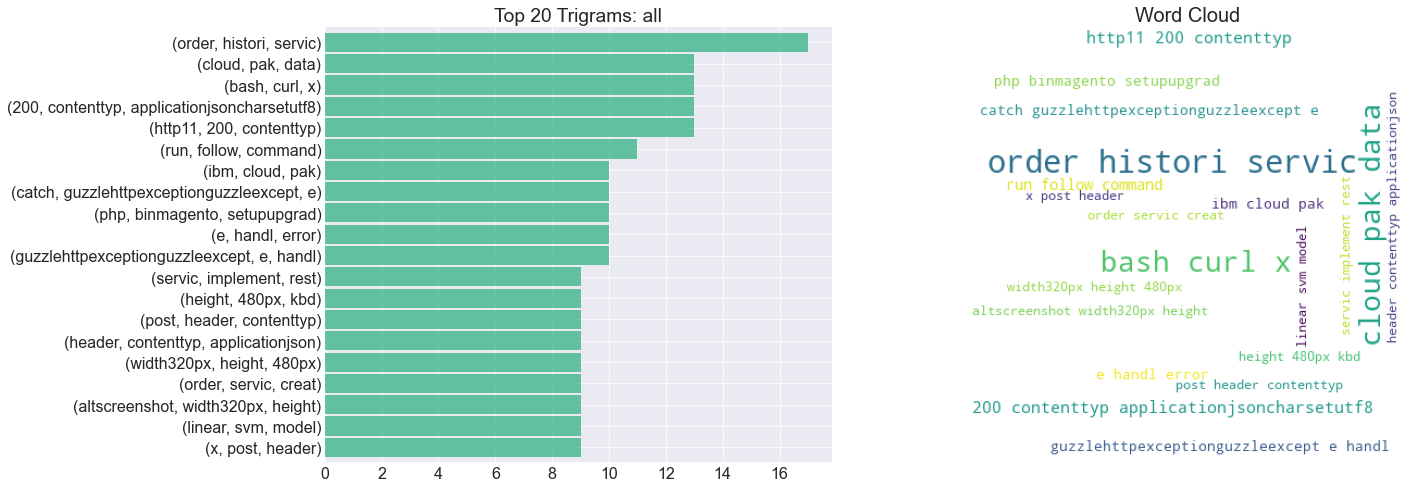

In [32]:
# take a look at the most common trigram for each language
for x, name in zip(all_the_words_list, cols):
    ex.trigram_count_word_cloud(x, title_name = name)

### Takeaways Bigrams and Trigrams with Stemmed Words
- There are no major commonalities between any of the bigrams or trigrams.
- With time we may attempt to create models off both bigrams and trigrams.

## Modeling

Because this class is a multi class classification problem we tried several machine learning algorithms for that specific target. 

We found that an SVC (support vector classifier) used on the lemmatized data had the highest accuracy score on the validate set (81%). And a INSERT SCORE HERE on the test data (the unseen data).

Among the models we tested were: INSERT MODEL NAMES HERE

We tried the models with stemmed and lemmatized data and without doing either of those. 

In [25]:
# reread in data to make sure no issues with data
df = pd.read_json('data2.json')
df = p.drop_unneeded_data(df)


df = p.prepare_nlp_data(df, content = 'readme_contents', extra_words=['customer', 'customers', '1', '2'])

We're trying first using a TD/IDF vectorizer on the lemmatized data. 

In [26]:
tfidf = TfidfVectorizer()
X_data = tfidf.fit_transform(df.lemmatized)
y_data = df.language

# use function from above (need to put in a module)
# split to X/y datasets 

X_train, y_train, X_validate, y_validate, X_test, y_test = m.nlp_X_train_split(X_data, y_data)

In [27]:
# create dataframe to stor the scores
score_df = pd.DataFrame(columns = ['model_name', 'train_score', 'validate_score'])

In [28]:
# create list of models to loop through
model_list = [MultinomialNB(), LinearSVC(), DecisionTreeClassifier(), RandomForestClassifier(), KNeighborsClassifier()]

# create list of model names that correspond to models
model_names = ['Naive_Bayes_tfidf', 'SVC_tfidf', 'Decision_tree_tfidf', 'Random_forest_tfidf', 'KNN_tfidf']

# initialize list of names of the languages
class_names = ['Java', 'JavaScript', 'Jupyter Notebook','PHP' ]

                   ============== Naive_Bayes_tfidf ================           
MultinomialNB()
~~~~~~~~Train Scores~~~~~~~~~
                  precision    recall  f1-score   support

            Java       1.00      0.62      0.77         8
      JavaScript       1.00      0.64      0.78        11
Jupyter Notebook       1.00      1.00      1.00        17
             PHP       0.76      1.00      0.86        22

        accuracy                           0.88        58
       macro avg       0.94      0.82      0.85        58
    weighted avg       0.91      0.88      0.87        58



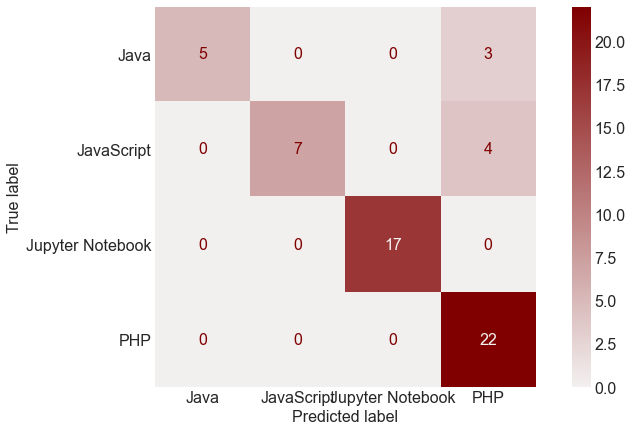


MultinomialNB()
~~~~~~~~Validate Scores~~~~~~~~~
                  precision    recall  f1-score   support

            Java       1.00      0.25      0.40         4
      JavaScript       0.00      0.00      0.00         5
Jupyter Notebook       1.00      0.71      0.83         7
             PHP       0.50      1.00      0.67        10

        accuracy                           0.62        26
       macro avg       0.62      0.49      0.47        26
    weighted avg       0.62      0.62      0.54        26



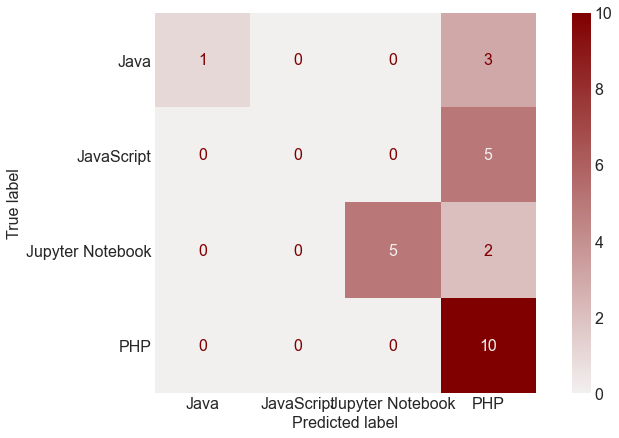


-------------------------------------------------------------------

                   ============== SVC_tfidf ================           
LinearSVC()
~~~~~~~~Train Scores~~~~~~~~~
                  precision    recall  f1-score   support

            Java       1.00      1.00      1.00         8
      JavaScript       1.00      1.00      1.00        11
Jupyter Notebook       1.00      1.00      1.00        17
             PHP       1.00      1.00      1.00        22

        accuracy                           1.00        58
       macro avg       1.00      1.00      1.00        58
    weighted avg       1.00      1.00      1.00        58



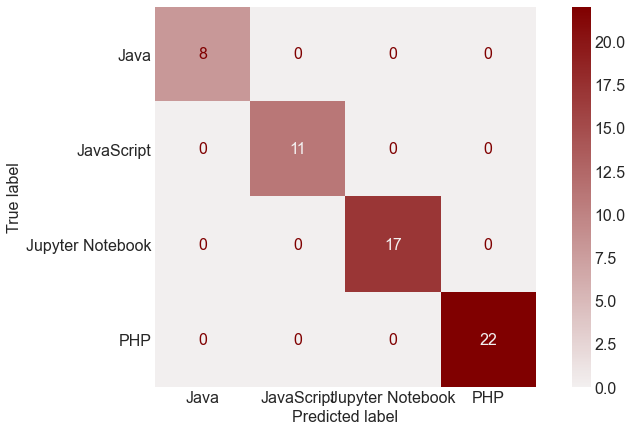


LinearSVC()
~~~~~~~~Validate Scores~~~~~~~~~
                  precision    recall  f1-score   support

            Java       1.00      0.25      0.40         4
      JavaScript       1.00      0.80      0.89         5
Jupyter Notebook       0.78      1.00      0.88         7
             PHP       0.83      1.00      0.91        10

        accuracy                           0.85        26
       macro avg       0.90      0.76      0.77        26
    weighted avg       0.88      0.85      0.82        26



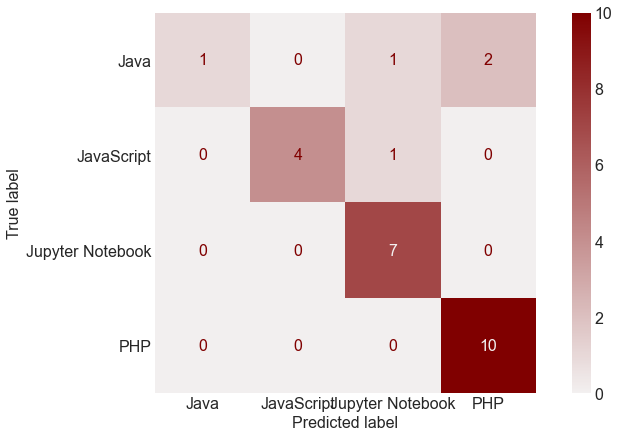


-------------------------------------------------------------------

                   ============== Decision_tree_tfidf ================           
DecisionTreeClassifier()
~~~~~~~~Train Scores~~~~~~~~~
                  precision    recall  f1-score   support

            Java       1.00      1.00      1.00         8
      JavaScript       1.00      1.00      1.00        11
Jupyter Notebook       1.00      1.00      1.00        17
             PHP       1.00      1.00      1.00        22

        accuracy                           1.00        58
       macro avg       1.00      1.00      1.00        58
    weighted avg       1.00      1.00      1.00        58



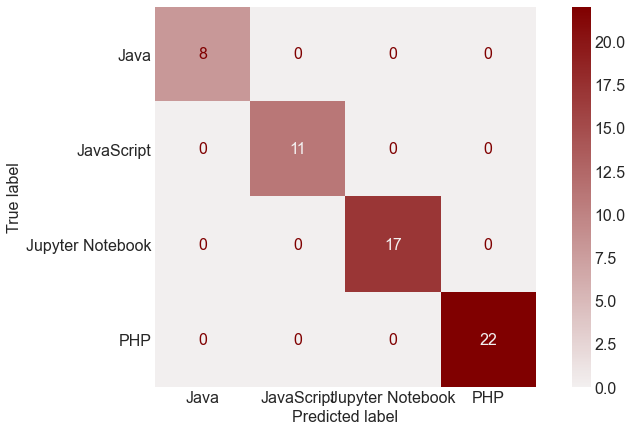


DecisionTreeClassifier()
~~~~~~~~Validate Scores~~~~~~~~~
                  precision    recall  f1-score   support

            Java       0.40      0.50      0.44         4
      JavaScript       1.00      1.00      1.00         5
Jupyter Notebook       0.44      0.57      0.50         7
             PHP       0.86      0.60      0.71        10

        accuracy                           0.65        26
       macro avg       0.68      0.67      0.66        26
    weighted avg       0.70      0.65      0.67        26



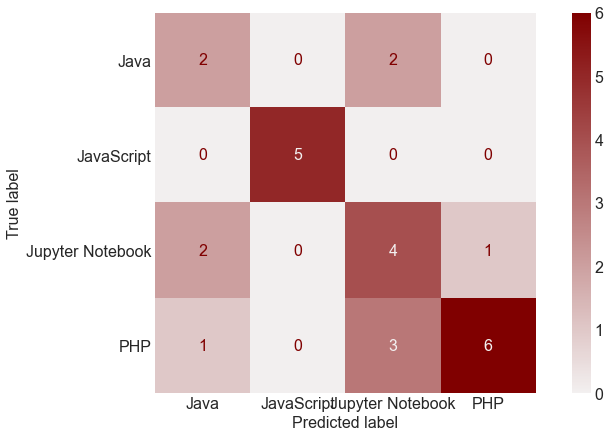


-------------------------------------------------------------------

                   ============== Random_forest_tfidf ================           
RandomForestClassifier()
~~~~~~~~Train Scores~~~~~~~~~
                  precision    recall  f1-score   support

            Java       1.00      1.00      1.00         8
      JavaScript       1.00      1.00      1.00        11
Jupyter Notebook       1.00      1.00      1.00        17
             PHP       1.00      1.00      1.00        22

        accuracy                           1.00        58
       macro avg       1.00      1.00      1.00        58
    weighted avg       1.00      1.00      1.00        58



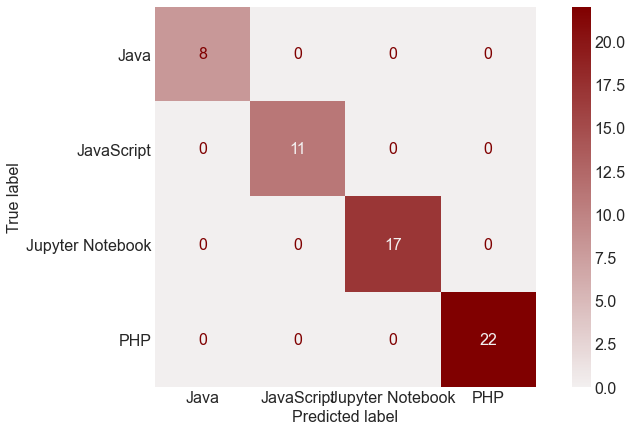


RandomForestClassifier()
~~~~~~~~Validate Scores~~~~~~~~~
                  precision    recall  f1-score   support

            Java       1.00      0.25      0.40         4
      JavaScript       1.00      0.60      0.75         5
Jupyter Notebook       0.47      1.00      0.64         7
             PHP       1.00      0.70      0.82        10

        accuracy                           0.69        26
       macro avg       0.87      0.64      0.65        26
    weighted avg       0.86      0.69      0.69        26



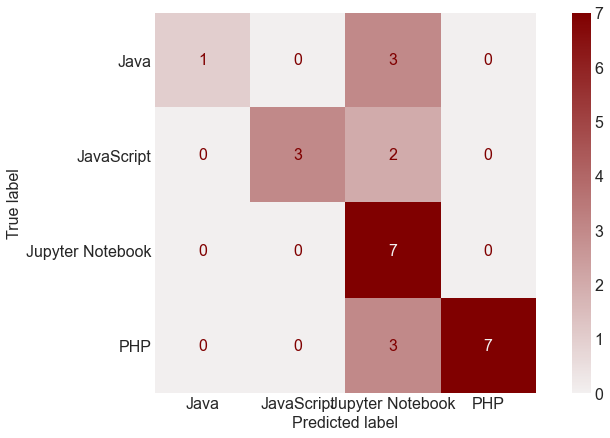


-------------------------------------------------------------------

                   ============== KNN_tfidf ================           
KNeighborsClassifier()
~~~~~~~~Train Scores~~~~~~~~~
                  precision    recall  f1-score   support

            Java       0.73      1.00      0.84         8
      JavaScript       0.89      0.73      0.80        11
Jupyter Notebook       0.94      1.00      0.97        17
             PHP       0.95      0.86      0.90        22

        accuracy                           0.90        58
       macro avg       0.88      0.90      0.88        58
    weighted avg       0.91      0.90      0.90        58



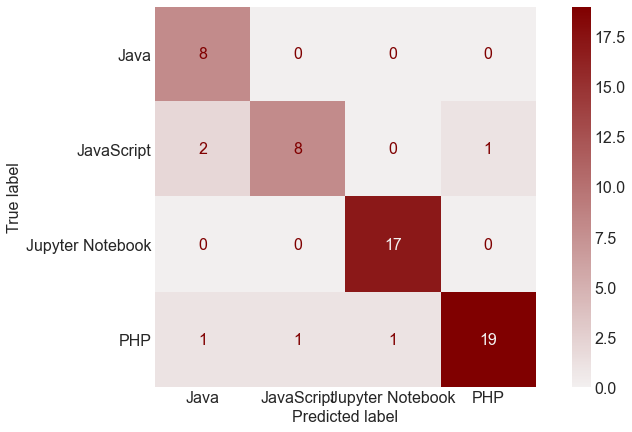


KNeighborsClassifier()
~~~~~~~~Validate Scores~~~~~~~~~
                  precision    recall  f1-score   support

            Java       0.50      0.50      0.50         4
      JavaScript       0.67      0.80      0.73         5
Jupyter Notebook       0.88      1.00      0.93         7
             PHP       1.00      0.80      0.89        10

        accuracy                           0.81        26
       macro avg       0.76      0.77      0.76        26
    weighted avg       0.83      0.81      0.81        26



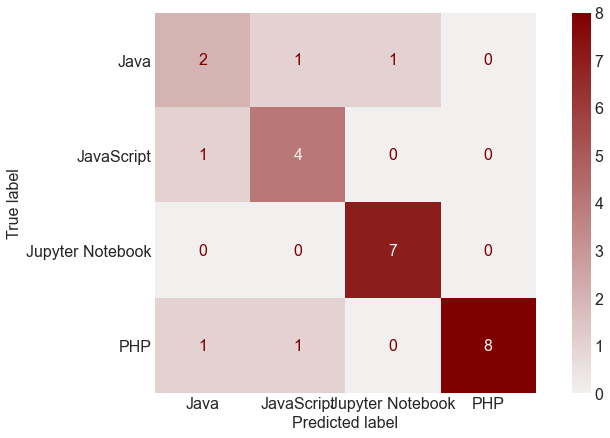


-------------------------------------------------------------------



In [29]:
for model, name in zip(model_list, model_names):
    score_df = m.test_a_model(X_train, y_train, X_validate, y_validate, model, name, score_df)
    
    m.make_models_and_print_metrics(model, name, X_train, y_train, X_validate, y_validate, class_names)

We model next with stemmed data still using the TD/IDF vectorizer.

In [30]:
# bring in the vectorizer
tfidf = TfidfVectorizer()

X_data = tfidf.fit_transform(df.stemmed)
y_data = df.language

# use function from above (need to put in a module)
# split to X/y datasets 

X_train, y_train, X_validate, y_validate, X_test, y_test = m.nlp_X_train_split(X_data, y_data)

In [31]:
# make a list of algorithms we want to try for our models
model_list = [MultinomialNB(), LinearSVC(), DecisionTreeClassifier(), RandomForestClassifier(), KNeighborsClassifier()]

# name the models
model_names = ['Naive_Bayes_stemmed', 'SVC_stemmed', 'Decision_tree_stemmed', 'Random_forest_stemmed', 'KNN_bigrams_stemmed']

# list the languages
class_names = ['Java', 'JavaScript', 'Jupyter Notebook','PHP' ]

In [32]:
for model, name in zip(model_list, model_names):
    score_df = m.test_a_model(X_train, y_train, X_validate, y_validate, model, name, score_df)

In [34]:
score_df

model_name  train_score  validate_score
0      Naive_Bayes_tfidf     0.879310        0.615385
1              SVC_tfidf     1.000000        0.846154
2    Decision_tree_tfidf     1.000000        0.653846
3    Random_forest_tfidf     1.000000        0.769231
4              KNN_tfidf     0.896552        0.807692
5    Naive_Bayes_stemmed     0.879310        0.615385
6            SVC_stemmed     1.000000        0.807692
7  Decision_tree_stemmed     1.000000        0.807692
8  Random_forest_stemmed     1.000000        0.692308
9    KNN_bigrams_stemmed     0.879310        0.769231

**Takeaways**
- Overall most of the models performed well but there is a drop off on the validate data
- It looks like most of the models utilizing the stemmed data are overfit
- Using the stemmed data does not give us better accuracy than the lemmatized data

Let's see how our models do with bigrams using lemmatized data. 

In [35]:
tfidf = TfidfVectorizer(ngram_range=(2,2))
X_data = tfidf.fit_transform(df.lemmatized)
y_data = df.language

X_train, y_train, X_validate, y_validate, X_test, y_test = m.nlp_X_train_split(X_data, y_data)

In [36]:
model_list = [MultinomialNB(), LinearSVC(), DecisionTreeClassifier(), RandomForestClassifier(), KNeighborsClassifier()]

model_names = ['Naive_Bayes_tfidf2', 'SVC_tfidf2', 'Decision_tree_tfidf2', 'Random_forest_tfidf2', 'KNN_bigrams_tfidf2']

class_names = ['Java', 'JavaScript', 'Jupyter Notebook','PHP' ]

In [37]:
for model, name in zip(model_list, model_names):
    score_df = m.test_a_model(X_train, y_train, X_validate, y_validate, model, name, score_df)

And now using just the clean data (not lemmatized or stemmed)

In [38]:
tfidf = TfidfVectorizer()
X_data = tfidf.fit_transform(df.clean)
y_data = df.language

X_train, y_train, X_validate, y_validate, X_test, y_test = m.nlp_X_train_split(X_data, y_data)

In [39]:
model_list = [MultinomialNB(), LinearSVC(), DecisionTreeClassifier(), RandomForestClassifier(), KNeighborsClassifier(n_neighbors=10, weights= 'distance')]

model_names = ['Naive_Bayes_tfidf_clean', 'SVC_tfidf_clean', 'Decision_tree_tfidf_clean', 'Random_forest_tfidf_clean', 'KNN_n10_tfidf_clean']

class_names = ['Java', 'JavaScript', 'Jupyter Notebook','PHP' ]

In [40]:
for model, name in zip(model_list, model_names):
    score_df = m.test_a_model(X_train, y_train, X_validate, y_validate, model, name, score_df)

In [46]:
score_df.sort_values(by = 'validate_score', ascending = False)

model_name  train_score  validate_score
1                   SVC_tfidf     1.000000        0.846154
16            SVC_tfidf_clean     1.000000        0.846154
19        KNN_n10_tfidf_clean     1.000000        0.807692
14         KNN_bigrams_tfidf2     0.862069        0.807692
4                   KNN_tfidf     0.896552        0.807692
6                 SVC_stemmed     1.000000        0.807692
7       Decision_tree_stemmed     1.000000        0.807692
3         Random_forest_tfidf     1.000000        0.769231
9         KNN_bigrams_stemmed     0.879310        0.769231
18  Random_forest_tfidf_clean     1.000000        0.730769
17  Decision_tree_tfidf_clean     1.000000        0.730769
8       Random_forest_stemmed     1.000000        0.692308
2         Decision_tree_tfidf     1.000000        0.653846
15    Naive_Bayes_tfidf_clean     0.879310        0.615385
0           Naive_Bayes_tfidf     0.879310        0.615385
11                 SVC_tfidf2     0.982759        0.615385
5         Naive_Bayes_stemmed     0.879310        0.615385
12       Decision_tree_tfidf2     1.000000        0.576923
10         Naive_Bayes_tfidf2     0.965517        0.423077
13       Random_forest_tfidf2     1.000000        0.384615

The top score is the Support Vector Classifier using the lemmatized data utilizing the TD/IDf method. 

### Testing on the unseen data

In [47]:
tfidf = TfidfVectorizer()
X_data = tfidf.fit_transform(df.lemmatized)
y_data = df.language

X_train, y_train, X_validate, y_validate, X_test, y_test = m.nlp_X_train_split(X_data, y_data)

                   ============== SVC ================           
LinearSVC()
~~~~~~~~Train Scores~~~~~~~~~
                  precision    recall  f1-score   support

            Java       1.00      1.00      1.00         8
      JavaScript       1.00      1.00      1.00        11
Jupyter Notebook       1.00      1.00      1.00        17
             PHP       1.00      1.00      1.00        22

        accuracy                           1.00        58
       macro avg       1.00      1.00      1.00        58
    weighted avg       1.00      1.00      1.00        58



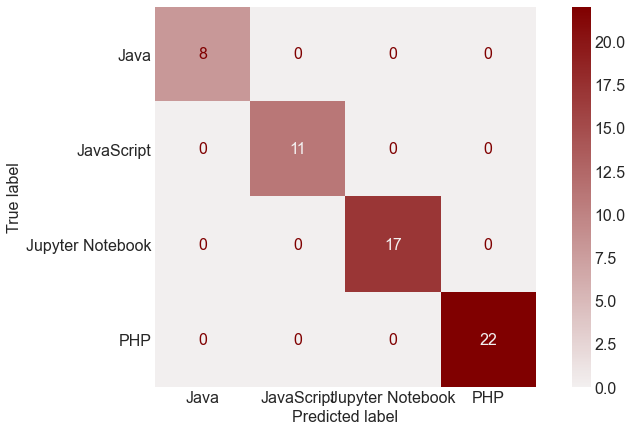


LinearSVC()
~~~~~~~~Validate Scores~~~~~~~~~
                  precision    recall  f1-score   support

            Java       1.00      0.33      0.50         3
      JavaScript       1.00      0.60      0.75         5
Jupyter Notebook       0.86      1.00      0.92         6
             PHP       0.73      1.00      0.84         8

        accuracy                           0.82        22
       macro avg       0.90      0.73      0.75        22
    weighted avg       0.86      0.82      0.80        22



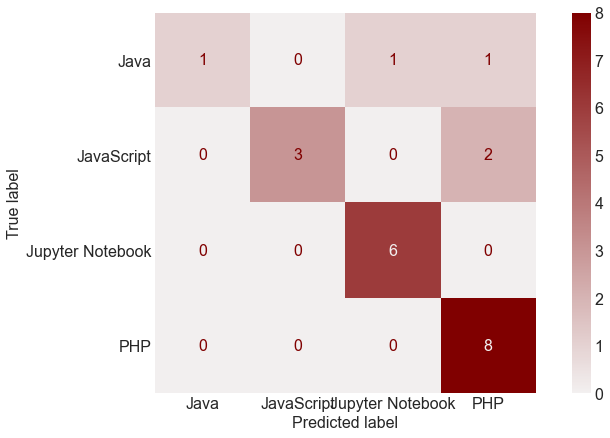


-------------------------------------------------------------------



In [50]:
# The second confusion matrix should be test
# maybe create new function for this 
m.make_models_and_print_metrics(LinearSVC(), 'SVC', X_train, y_train, X_test, y_test, class_names)